In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools

import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg

from scipy.stats import mode
dy_name = 'evariant_loop_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    DJ.makedir(private_out)

import vapeplot

from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerBase
from matplotlib.transforms import Bbox, TransformedBbox,blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,BboxConnectorPatch

import gc

In [2]:
outdir = private_out + '/qtl_results_v4'

if not os.path.exists(outdir):
    DJ.makedir(outdir)

In [175]:
def vc_unique_add_proportion(df, gb, col_unique):
    """groupby two categories, and count the number of unique elements in the third
    and proportion of total unique elements"""
    vc = df.groupby((gb[0], gb[1]))[col_unique].apply(lambda x: len(set(x))).to_frame('count').reset_index()
    vc_tot = df.groupby(gb[0])[col_unique].apply(lambda x: len(set(x))).to_frame('total')
    vc = vc[vc[gb[1]] == True]
    vc = vc.set_index(gb[0])
    vc = vc.join(vc_tot)
    vc['fraction'] = vc['count'] / vc['total']
    return vc

def vc_w_prop(df, gb_col, bool_col):
    vc = df.groupby(gb_col)[bool_col].value_counts().to_frame('count')
    vc_frac = df.groupby(gb_col)[bool_col].value_counts(normalize = True).to_frame('fraction')
    vc = vc.join(vc_frac)
    vc = vc.reset_index()
    tot = vc.groupby(gb_col)['count'].sum().to_frame('total')
    
    vc = vc[vc[bool_col] == True] 
    
    vc = vc.set_index(gb_col).join(tot)
    vc = vc.reset_index()
    return vc

In [3]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats_r = importr('stats')

# from rpy2.robjects.packages import importr
utils = importr('utils')

def add_bh_fdr(top, col):
    top = top.copy()
    p_vals = top[col].tolist()
    p_adjust = stats_r.p_adjust(FloatVector(p_vals), method = 'fdr')
    top['fdr_corrected_p'] = list(p_adjust)
    return top

In [4]:
def vc_to_or(vc, v = False):
    def default_loc(df, a, b, default = 0):
        try:
            out = df.loc[a,b]
            return out
        except:
            return default

        
    if not v:
        
        t_g1 = [default_loc(vc, True, True), default_loc(vc, True, False)]
        f_g1 = [default_loc(vc, False, True), default_loc(vc, False, False)]
        v = [t_g1, f_g1]
    else:
        v = vc

    try:
        odds_ratio, p_fisher = stats.fisher_exact(v, )
    except:
        odds_ratio, p_fisher = (np.NaN, np.NaN)
    
    
    return v, odds_ratio, p_fisher

In [5]:
def annotate_tests_data(df, col = "significant"):
    df = df.copy()
    def safe_div(a, b):
        try:
            out = a/b
        except:
            out = np.NaN
        return out
            
#     df['frac_non_{}_ol_feat'.format(col)] = df['{}_False'.format(col)].apply(lambda x: safe_div(x[1], x[0]))
#     df['frac_{}_ol_feat'.format(col)] =  df['{}_True'.format(col)].apply(lambda x: safe_div(x[1], x[0]))
    try:
        df['-log10p_fisher'] = np.log10(df['p_fisher']) * -1
    except:
        pass
    
    try:
        df['log_odds_ratio'] = np.log10(df['odds_ratio'])
    except:
        pass
    
    try:
        df['log2_odds_ratio'] = np.log2(df['odds_ratio'])
    except:
        pass
    df = df.reset_index()
    
    df['log2_odds_ratio_raw'] = df['log2_odds_ratio']
    
    
    t_neg_inf = df.log2_odds_ratio == (-np.inf)
    t_pos_inf = (df.log2_odds_ratio == (np.inf))
    
    exclude = t_neg_inf[t_neg_inf].index.tolist() + t_pos_inf[t_pos_inf].index.tolist()
    if len(exclude) > 0:
        inds_non_inf = set(df.index.tolist()).difference(exclude)

        if t_neg_inf[t_neg_inf].shape[0] > 0:
            inds = t_neg_inf[t_neg_inf].index.tolist()
            try:
                m = df.loc[inds_non_inf].log2_odds_ratio.min()
            except:
                m = -1
            
            if m >= -0.5:
                m = -1
            df.loc[inds, 'log2_odds_ratio'] = m
            
        if t_pos_inf[t_pos_inf].shape[0] > 0:
            inds = t_pos_inf[t_pos_inf].index.tolist()
            try:
                m = df.loc[inds_non_inf].log2_odds_ratio.max()
            except:
                m = 2
            if m < 0:
                m = 2
            df.loc[inds, 'log2_odds_ratio'] = m
            
    return df

In [7]:
def prep_per_variant_df(per_var_info, var_egene):
    var_egene_nr = var_egene[(var_egene.most_significant_nr)]
    nr_ids = var_egene.Non_Redundant_ID.unique().tolist()
    sig_assoc = var_egene[var_egene.significant==True].Non_Redundant_ID.unique().tolist()
    th_assoc = var_egene[var_egene.top_hit_final_sig==True].Non_Redundant_ID.unique().tolist()
    
#     per_var_info = pd.DataFrame(index = nr_ids)
    per_var_info['significant_association'] = per_var_info.index.isin(sig_assoc)
    per_var_info['lead_association'] = per_var_info.index.isin(th_assoc)
    
    
    num_egenes_total = (var_egene[var_egene.significant==True]
                    .groupby('Non_Redundant_ID').feature_id.apply(lambda x: len(set(x))))
    num_egenes_th = (var_egene[var_egene.top_hit_final_sig]
                 .groupby('Non_Redundant_ID').feature_id.apply(lambda x: len(set(x))))
    num_genes_tested = var_egene.groupby('Non_Redundant_ID').feature_id.apply(lambda x: len(set(x)))
    thresh = 10000
    num_genes_tested_loop = (var_egene[(var_egene.min_dist_pc_anchor < thresh) & 
                                      (var_egene.closer_to_inside_proximal == 
                                       False) & (var_egene.coding == False)].groupby('Non_Redundant_ID').feature_id.unique().apply(len))
    num_egenes_loop = var_egene[(var_egene.min_dist_pc_anchor < thresh) 
                                & (var_egene.significant==True) & 
                                (var_egene.closer_to_inside_proximal ==
                                 False) & (var_egene.coding==False)].groupby('Non_Redundant_ID').feature_id.unique().apply(len)
    
    num_egenes_loop_th =  var_egene[(var_egene.min_dist_pc_anchor < thresh) & (var_egene.top_hit_final_sig==True) & (var_egene.closer_to_inside_proximal == False) & (var_egene_nr.coding == False)].groupby('Non_Redundant_ID').feature_id.unique().apply(len)
    

    
    num_genes_tested_nonloop = (var_egene[(var_egene.min_dist_pc_anchor > thresh) & 
                                      (var_egene.closer_to_inside_proximal == 
                                       False) & (var_egene.coding == False)].groupby('Non_Redundant_ID').feature_id.unique().apply(len))
    num_egenes_nonloop = var_egene[(var_egene.min_dist_pc_anchor > thresh) 
                                & (var_egene.significant==True) & 
                                (var_egene.closer_to_inside_proximal ==
                                 False) & (var_egene.coding==False)].groupby('Non_Redundant_ID').feature_id.unique().apply(len)
    

    num_egenes_nonloop_th = var_egene[(var_egene.min_dist_pc_anchor > thresh) 
                                & (var_egene.top_hit_final_sig==True) & 
                                (var_egene.closer_to_inside_proximal ==
                                 False) & (var_egene.coding==False)].groupby('Non_Redundant_ID').feature_id.unique().apply(len)
    
    
    num_genes_tested_da = (var_egene[(var_egene.min_dist_pc_anchor > thresh) & 
                                      (var_egene.dist_tss_abs > thresh) & 
                                     (var_egene.genic_category_variant == 'intergenic')
                                    ].groupby('Non_Redundant_ID').feature_id.unique().apply(len))
    num_egenes_da = (var_egene[(var_egene.min_dist_pc_anchor > thresh) & 
                                      (var_egene.dist_tss_abs > thresh) & 
                                     (var_egene.genic_category_variant == 'intergenic') &
                               (var_egene.significant == True)
                                    ].groupby('Non_Redundant_ID').feature_id.unique().apply(len))
    num_egenes_da_th = (var_egene[(var_egene.min_dist_pc_anchor > thresh) & 
                                      (var_egene.dist_tss_abs > thresh) & 
                                     (var_egene.genic_category_variant == 'intergenic') &
                               (var_egene.top_hit_final_sig == True)
                                    ].groupby('Non_Redundant_ID').feature_id.unique().apply(len))


    per_var_info['num_genes_tested_loop'] = num_genes_tested_loop
    
    per_var_info['num_egenes_loop'] = num_egenes_loop
    per_var_info['num_egenes_loop_th'] = num_egenes_loop_th
    
    per_var_info['num_egenes'] = num_egenes_total
    
    per_var_info['num_egenes_lead'] = num_egenes_th
    per_var_info['num_genes_tested'] = num_genes_tested
    
    per_var_info['num_genes_tested_da'] = num_genes_tested_da
    per_var_info['num_egenes_da'] = num_egenes_da
    per_var_info['num_egenes_da_lead'] = num_egenes_da_th
    
    
    
    
    
#     per_var_info = per_var_info.join(num_genes_tested_loop.to_frame('num_genes_tested_loop'), 
#                                  lsuffix='_loop', rsuffix= '')
#     per_var_info = per_var_info.join(num_egenes_loop.to_frame('num_egenes_loop'), lsuffix='_loop', rsuffix= '')
#     per_var_info = per_var_info.join(num_egenes_loop_th.to_frame('num_egenes_loop_th'), lsuffix='_loop', rsuffix= '')
#     per_var_info = per_var_info.join(num_egenes_total.to_frame('num_egenes'), lsuffix='_loop', rsuffix= '')
#     per_var_info = per_var_info.join(num_egenes_th.to_frame('num_egenes_lead'), lsuffix='_loop', rsuffix= '')
#     per_var_info = per_var_info.join(num_genes_tested.to_frame('num_genes_tested'), lsuffix='_loop', rsuffix= '')
    
    cols = 'num_egenes	num_egenes_lead'.split()
    per_var_info[cols] = per_var_info[cols].fillna(0)

    cols = 'num_egenes_loop	num_egenes_loop_th num_genes_tested_loop'.split()
    per_var_info[cols] = per_var_info[cols].fillna(0)
    
    # distal non-exonic but not overlapping the loop anchor (10kb thresh)
    per_var_info['num_nonloop_egenes_lead'] = num_egenes_nonloop_th
    per_var_info['num_nonloop_egenes'] = num_egenes_nonloop
    
    per_var_info['num_nonloop_tested'] = num_genes_tested_nonloop
    
    # Exonic non-exonic- probably change the naming from coding (people get confused about protein coding)
    coding_egenes = var_egene_nr[(var_egene_nr.coding == True) & (var_egene_nr.significant)].groupby('NR_ID').feature_id.unique().apply(len)

    ncoding_egenes = var_egene_nr[(var_egene_nr.coding == False) & (var_egene_nr.significant)].groupby('NR_ID').feature_id.unique().apply(len)

    coding_tested = var_egene_nr[(var_egene_nr.coding == True)].groupby('NR_ID').feature_id.unique().apply(len)
    ncoding_tested = var_egene_nr[(var_egene_nr.coding == False)].groupby('NR_ID').feature_id.unique().apply(len)

    coding_lead = var_egene_nr[(var_egene_nr.coding == True) & (var_egene_nr.top_hit_final_sig)].groupby('NR_ID').feature_id.unique().apply(len)
    ncoding_lead = var_egene_nr[(var_egene_nr.coding == False) & (var_egene_nr.top_hit_final_sig)].groupby('NR_ID').feature_id.unique().apply(len)

    # coding_tested = var_egene_nr[(var_egene_nr.coding == True)].groupby('NR_ID').feature_id.unique().apply(len)
    # ncoding_tested = var_egene_nr[(var_egene_nr.coding == False)].groupby('NR_ID').feature_id.unique().apply(len)

    per_var_info['num_coding_egenes_lead'] = coding_lead
    per_var_info['num_noncoding_egenes_lead'] = ncoding_lead


    per_var_info['num_coding_egenes'] = coding_egenes
    per_var_info['num_noncoding_egenes'] = ncoding_egenes

    per_var_info['num_coding_tested'] = coding_tested
    per_var_info['num_noncoding_tested'] = ncoding_tested
    
        
    

    cols = ['num_coding_egenes_lead', 'num_noncoding_egenes_lead', 'num_coding_egenes', 
     'num_noncoding_egenes','num_noncoding_tested', 'num_coding_tested', 'num_nonloop_egenes_lead',
           'num_nonloop_egenes', 'num_nonloop_tested', 'num_genes_tested_da', 
            'num_egenes_da', 'num_egenes_da_lead']
    per_var_info[cols] = per_var_info[cols].fillna(0)
    
    return per_var_info

In [173]:
def add_svtype_cats(all_qtls_filt):
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV', 'SNV': 'SNV', 'INDEL_DEL': 'INDEL', 
               'INDEL_INS': 'INDEL'}
    all_qtls_filt['SVTYPE_SUPER'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'SV'))
    convert = {'STR':'STR', 'INDEL': 'INDEL', 'SNP': 'SNV',
               'ALU': 'MEI', 'LINE1': 'MEI', 'SVA':'MEI', 'rMEI':'MEI', 
          'DUP': 'CNV', 'DEL': 'CNV', 'mCNV': 'CNV', 'SNV': 'SNV', 'INDEL_INS': 'INDEL', 'INDEL_DEL': 'INDEL', 
              'INDEL': 'INDEL', 'SNP': "SNV"}
    all_qtls_filt['SVTYPE_COLLAPSE'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x, 'other SV'))
    convert = {'LINE1':'MEI', 'SVA': 'MEI', 'ALU': 'MEI'}
    all_qtls_filt['SVTYPE_NR_C'] = all_qtls_filt.SVTYPE_NR.apply(lambda x: convert.get(x,x))
    return all_qtls_filt

In [78]:
def fix_svtypes(info_all_rna, suff = '_all'):
    svt_col = "SVTYPE{}".format(suff)
    st_col = "SUBTYPE{}".format(suff)
    
    inds = info_all_rna[(info_all_rna[svt_col] == 'mCNV') & (info_all_rna[st_col] == 'DEL')].index.tolist()

    inds_nr = info_all_rna[(info_all_rna[svt_col] == 'mCNV') & (info_all_rna[st_col] == 'DEL') & 
                           (info_all_rna.ID == info_all_rna.NR_ID)].index.tolist()
    
    info_all_rna.loc[inds_nr, "SVTYPE_NR"] = 'DEL'

    info_all_rna.loc[inds, svt_col] = 'DEL'

In [8]:
var_egene = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/var_egene_annot_maf5_sv_only.pkl')
var_egene.feature_id.unique().shape
var_egene_nr = var_egene[(var_egene.most_significant_nr)]

In [80]:
var_egene_nr['ID']= var_egene_nr.snp_id

In [81]:
var_egene_nr.pipe(fix_svtypes, suff = '')

In [86]:
# var_egene_nr.groupby(('SVTYPE', 'significant')).SUBTYPE.value_counts(normalize = True)

In [9]:
per_var = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/per_variant_info_sv_only.pkl').pipe(prep_per_variant_df, var_egene_nr)

In [90]:
per_var.pipe(fix_svtypes, suff = '')

In [93]:
per_var[per_var.SVTYPE == 'mCNV'].groupby(('SVTYPE', 'significant_association')).SUBTYPE.value_counts()

SVTYPE  significant_association  SUBTYPE
mCNV    False                    MIXED      385
                                 DUP        107
        True                     MIXED      323
                                 DUP        102
Name: SUBTYPE, dtype: int64

In [98]:
per_var['ALLELES_str'] = per_var.ALLELES.apply(lambda x: ",".join(map(str,x)))

In [109]:
per_var['num_observed_alleles'] = per_var.ALLELES.apply(len)

In [108]:
per_var[(per_var.SVTYPE == 'mCNV') & (per_var.significant_association)].ALLELES.apply(len).value_counts()

4     182
5     109
3      50
6      44
7      20
9       9
8       7
18      1
13      1
12      1
10      1
Name: ALLELES, dtype: int64

In [ ]:
per_var = per_var.pipe(add_svtype_cats)

In [159]:
CM.save_dataframe('per_variant_info_annot_update', per_var, outdir)

per_variant_info_annot_update = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/per_variant_info_annot_update.pkl')
per_variant_info_annot_update = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/per_variant_info_annot_update.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/load_pickled_nb_variables.py


# mCNVs and eQTLs

In [115]:
tdf = per_var[(per_var.SVTYPE == 'mCNV') & (per_var.significant_association)].groupby('num_egenes').num_observed_alleles.value_counts().to_frame('num').reset_index()

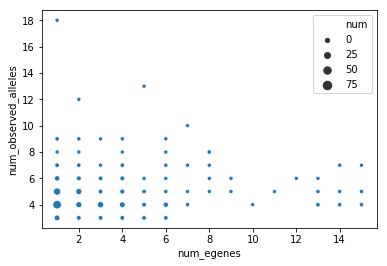

In [117]:
sns.scatterplot(x = 'num_egenes', y = 'num_observed_alleles', size = 'num', data = tdf)

In [14]:
per_var['frac_loop_eg'] = per_var.num_egenes_loop/per_var.num_genes_tested_loop
per_var['frac_nonloop_eg'] = per_var.num_egenes_da/per_var.num_genes_tested_da

In [66]:
info_pass_rna = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/dosage_vcf_and_variant_info/info_unfilt_consented_472_v2.pkl')
# info_pass = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/dosage_vcf_and_variant_info/info_pass_consented_annot_472.pkl')

info_pass_rna = info_pass_rna[~info_pass_rna['CHROM'].isin(['X', 'Y'])]

In [152]:
# info_pass_rna[(info_pass_rna.SVTYPE_all == 'mCNV') & (info_pass_rna.SUBTYPE_all == 'DEL')]

In [153]:
pvt = per_var[((per_var.num_genes_tested_loop > 0) & (per_var.num_genes_tested_da > 0)) &
              ((per_var.num_egenes_da > 0) | (per_var.num_egenes_loop > 0))]

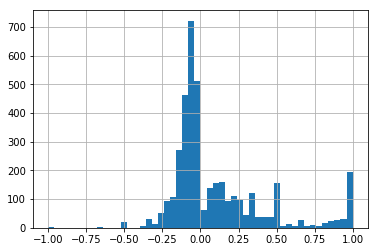

In [154]:
(pvt.frac_loop_eg - pvt.frac_nonloop_eg).hist(bins = 50)

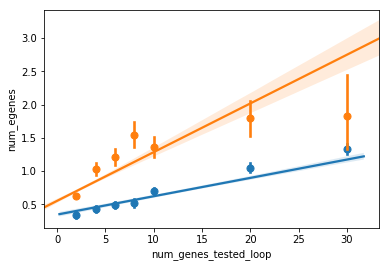

In [84]:
pvt = per_var[(per_var.num_genes_tested_loop > 0)]

fig, ax = plt.subplots(1,1)

sns.regplot(y = 'num_egenes', x = 'num_nonloop_tested', data = pvt[pvt.num_nonloop_tested > 0],
           x_bins = [2, 4,6,8,10, 20, 30], label = 'nonloop_vs_ev')


sns.regplot(y = 'num_egenes', x = 'num_genes_tested_loop', data = pvt[pvt.num_genes_tested_loop > 0], label = 'loop_vs_ev', x_bins = [2, 4,6,8,10, 20, 30])




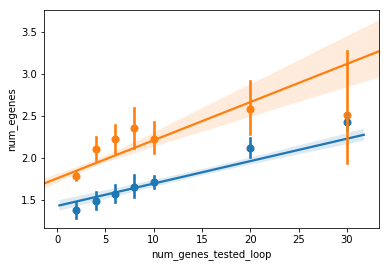

In [85]:
pvt = per_var[(per_var.num_genes_tested_loop > 0) & (per_var.num_egenes > 0)]

fig, ax = plt.subplots(1,1)

sns.regplot(y = 'num_egenes', x = 'num_nonloop_tested', data = pvt[pvt.num_nonloop_tested > 0],
           x_bins = [2, 4,6,8,10, 20, 30], label = 'nonloop_vs_ev')


sns.regplot(y = 'num_egenes', x = 'num_genes_tested_loop', data = pvt[pvt.num_genes_tested_loop > 0], label = 'loop_vs_ev', x_bins = [2, 4,6,8,10, 20, 30])


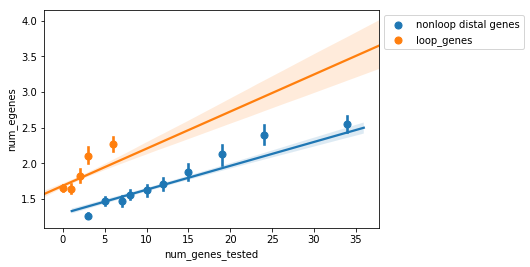

In [113]:
pvt = per_var[per_var.num_egenes > 0]
fig, ax = plt.subplots(1,1)

sns.regplot(y = 'num_egenes', x = 'num_nonloop_tested', data = pvt,
           x_bins = 10, label = 'nonloop distal genes')


sns.regplot(y = 'num_egenes', x = 'num_genes_tested_loop', data = pvt, label = 'loop_genes', x_bins = 10)


ax.set_xlabel('num_genes_tested')

ax.legend(bbox_to_anchor= (1,1), loc = 'upper left')

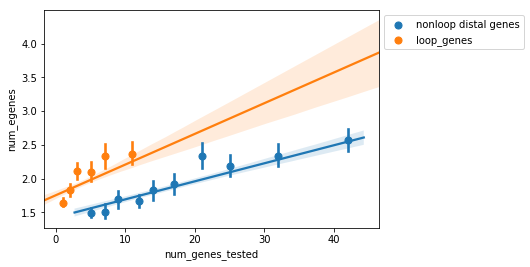

In [87]:
pvt = per_var[(per_var.num_genes_tested_loop > 0) & (per_var.num_egenes > 0)]
fig, ax = plt.subplots(1,1)

sns.regplot(y = 'num_egenes', x = 'num_nonloop_tested', data = pvt[pvt.num_nonloop_tested > 0],
           x_bins = 10, label = 'nonloop distal genes')


sns.regplot(y = 'num_egenes', x = 'num_genes_tested_loop', data = pvt[pvt.num_genes_tested_loop > 0], label = 'loop_genes', x_bins = 10)

ax.set_xlabel('num_genes_tested')
ax.legend(bbox_to_anchor= (1,1), loc = 'upper left')

In [88]:
t =(pvt.num_genes_tested_loop > 0).to_frame('connected_by_looping_to_some')

In [52]:
var_egene_nr = var_egene_nr.merge(t, left_on='NR_ID', right_index=True, how = 'left')

# Loop eGene Matrix 

In [160]:
bins = [0.5, 1.5, 6, 11, 21, 10000]
bin_labels = ['1', '2-5', '6-10', '11-20', '21+']

per_var['num_genes_tested_loop_bin'] = pd.cut(per_var.num_genes_tested_loop, bins = bins, labels = bin_labels, include_lowest=True).astype(str)

In [161]:
vc_all = per_var[per_var.num_egenes_loop > 0].groupby(('num_genes_tested_loop', 'num_egenes_loop')).size().to_frame('count').reset_index()

In [162]:
bins = [0,1.5] + [5, 10, 20, 30, 1000]
nbins = np.arange(0, len(bins[1:]))
order_bins = dict(zip(bins[1:], nbins))
vc_all['num_genes_tested_loop_bin'] = pd.cut(vc_all.num_genes_tested_loop, bins = bins, labels = bins[1:])

In [163]:
vc_all['order_bins'] = vc_all.num_genes_tested_loop_bin.map(order_bins)
vc_all.num_genes_tested_loop_bin = vc_all.num_genes_tested_loop_bin.astype(int)

In [164]:
mat = vc_all.groupby(('num_genes_tested_loop_bin', 'order_bins','num_egenes_loop'))['count'].sum().to_frame('count').reset_index().fillna(0)

In [165]:
mat = pd.pivot_table(mat.sort_values(['order_bins', 'num_egenes_loop']),values = 'count', index = 'num_genes_tested_loop_bin', columns='num_egenes_loop').fillna(0)

In [166]:
mat = mat.applymap(int)
mat.columns = mat.columns.astype(int)

In [168]:
CM.save_dataframe('num_loops_per_egene_mat', mat, outdir)

num_loops_per_egene_mat = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/num_loops_per_egene_mat.pkl')
num_loops_per_egene_mat = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/num_loops_per_egene_mat.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/load_pickled_nb_variables.py


In [169]:
xticklabels = ['1', '2-5', '6-10', '11-20', '21-30', '31+']

In [171]:
log_norm = LogNorm(vmin=1, vmax=500)

[Text(0,0.5,'1'),
 Text(0,1.5,'2'),
 Text(0,2.5,'3'),
 Text(0,3.5,'4'),
 Text(0,4.5,'5'),
 Text(0,5.5,'6'),
 Text(0,6.5,'7')]

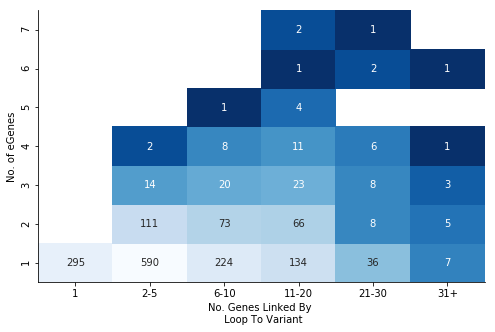

In [172]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax = sns.heatmap(mat.T, annot = True, fmt = "0", vmin = 1, vmax = 500, norm=log_norm, cmap='Blues_r', cbar = False)
ax.invert_yaxis()
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_xlabel('No. Genes Linked By \n Loop To Variant')
ax.set_ylabel('No. of eGenes')
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(map(int, ax.get_yticks()))
ax.set_yticklabels(range(1,8))

# Percentage eQTLs 

In [178]:
var_egene_nr_nc_nd = var_egene_nr[(var_egene_nr.coding == False) & (var_egene_nr.genic_category_variant != 'intersects_promoter') & (var_egene_nr.near_distal_loop == True)]

In [179]:
# the fraction of significant var-egene pairs near distal eQTL
t1 = vc_w_prop(var_egene_nr_nc_nd[var_egene_nr_nc_nd.int_distal_pc_10kb == True], 'SVTYPE_NR_C', 'significant') 
t2 = vc_w_prop(var_egene_nr_nc_nd[var_egene_nr_nc_nd.int_distal_pc_10kb == False], 'SVTYPE_NR_C', 'significant') 
t1['intersects_anchor'] = True
t2['intersects_anchor'] = False
df = pd.concat([t1,t2])

In [181]:
CM.save_dataframe('vc_pc10_sv_only', df, outdir)

vc_pc10_sv_only = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/vc_pc10_sv_only.pkl')
vc_pc10_sv_only = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/vc_pc10_sv_only.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/evariant_loop_analysis/qtl_results_v4/load_pickled_nb_variables.py
